In [242]:
import pandas as pd 
pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
from cmlreaders import get_data_index
import xarray as xarray
import matplotlib.pyplot as plt
from pylab import *
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
from general import *
from SWRmodule import *
from HFA_ripples_analysis import HFA_ripples_analysis
import seaborn as sns

In [243]:
# init variables
sub_selection = 'whole'
df = get_data_index("r1") # all RAM subjects
exp = 'catFR1' # 'FR1' 'catFR1' 'RepFR1'

data_folder = 'SWR_scratch'
select_subfield = True
ripple_bin_start_end = [100, 1100]
hpc_region = ['ca1', 'ca3', 'dg']
ripple_region = ['ca1', 'ca3', 'dg']
hpc_ripple_type = 'single_elec'
region_name = 'HPC'


RS = HFA_ripples_analysis(exp=exp, df=df, sub_selection=sub_selection, data_folder=data_folder,
                                        select_subfield=select_subfield, hpc_regions=hpc_region, ripple_regions=ripple_region, 
                                        ripple_bin_start_end=ripple_bin_start_end)

RS.remove_subject_sessions()
RS.load_data_from_cluster(base_path='/scratch/efeghhi/', selected_period='encoding', region_name=region_name, 
                          hpc_ripple_type='single_elec', ripple_bool=False)
RS.getStartArray()
RS.select_idxs_numpy()

/home1/efeghhi/ripple_memory/ripples_HFA_general.py:104: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ((self.df.subject!='R1239E') | (self.df.session!=0)) # some correlated noise (can see in catFR1 problem sessions ppt)


catFR1
**Done reading data**
From 230/230 sessions with >0 HPC electrodes
Total trials: 235018
Unique sessions: 230
...from 121 patients
Number of electrodes: 595
Electrode regions X sessions:
259 for left ca1
3 for left ca2
4 for left ca3
148 for left dg
247 for left hippocampus
37 for left sub
222 for right ca1
99 for right dg
183 for right hippocampus
44 for right sub
Creating semantic array
Selecting 149736 trials out of 235018 trials
Number of unique patients: 94
Number of unique sessions: 169


In [368]:
def SEM(vec, axis_num):
    return np.std(vec, axis=axis_num)/(vec.shape[0]**.5)

def plot_clustered_vs(freq_band_arr, freq_band_labels, idx1, idx2, label1, label2, append_next_word, title):
    
    fig, ax = plt.subplots(1,len(freq_band_arr),figsize=(5*len(freq_band_arr),5))
    
    for i, (freq_band, freq_label) in enumerate(zip(freq_band_arr, freq_band_labels)):
        
        freq_band_1 = freq_band[idx1]
        freq_band_2 = freq_band[idx2]
        
        if append_next_word:
            freq_band_1_next_word = freq_band[idx1+1]
            freq_band_1 = np.concatenate((freq_band_1, freq_band_1_next_word), -1)
            freq_band_2_next_word = freq_band[idx2+1]
            freq_band_2 = np.concatenate((freq_band_2, freq_band_2_next_word), -1)
            
        if i == 0:
            ax[0].set_ylabel("Normalized power", fontsize=14)
        if i == 1:
            ax[i].text(13, -1.4, "Time (100 ms bins)", size=14)
        ax[i].set_ylim(-1,1.1)
        ax[i].set_title(freq_label, fontsize=16)
        ax[i].errorbar(x=np.arange(1,61,1), y=np.mean(freq_band_1, axis=0), yerr=SEM(freq_band_1,0), color='r', label=f'{label1} ({freq_band_1.shape[0]})')
        ax[i].errorbar(x=np.arange(1,61,1), y=np.mean(freq_band_2, axis=0), yerr=SEM(freq_band_2,0), color='b', label=f'{label2} ({freq_band_2.shape[0]})')
        ax[i].fill_between(np.arange(11, 18), 1.1,-1)
        ax[i].text(10, -1.25, 'Word 1', size=12)
        ax[i].text(40, -1.25, 'Word 2', size=12)
        if append_next_word:
            ax[i].axvline(freq_band_1.shape[-1]/2, color='black', linestyle='--')
            ax[i].fill_between(np.arange(11+30, 18+30), 1.1,-1)
    
    plt.legend()
    fig.suptitle(title, fontsize=20) 
    
    return freq_band_1, freq_band_2
def create_semantic_clustered_array(clustered=['A', 'C'], unclustered=['D', 'Z']):
        
        '''
        :param list clustered: indicates what recalls count as clustered. There are four possible recalls:
            1) 'A': adjacent semantic
            2) 'C': remote semantic
            3) 'D': remote unclustered
            4) 'Z': dead end 
        The default is to use A and C as clustered, and D and Z as unclustered. 
        '''
        
        RS.number_of_lists = int(RS.num_selected_trials/RS.list_length)
        
        semantic_clustered_array_np = np.zeros((RS.number_of_lists, RS.list_length))
        RS.dead_ends = 0
        RS.remote_semantic = 0
        RS.adjacent_semantic = 0
        RS.remote_nonsemantic = 0
        RS.adjacent_nonsemantic = 0
        
        counter = 0
        
        for list_idx in range(0, RS.num_selected_trials, RS.list_length):
            
            # recall_position_np and semantic_array_np contain information 
            # about the word that was recalled and its clustering type, respectively
            # this information is repeated list_length times, so our for loop will 
            # increment by list length 
            recalled_idx = RS.recall_position_np[list_idx] 
            cluster = RS.semantic_array_np[list_idx]
            
            # init values to -1 so that non recalled items are -1 
            cluster_trial_np = np.ones(RS.list_length)*-1
            
            for r, c in zip(recalled_idx, cluster):
                if r > 0 and r <= RS.list_length:
                    if c in clustered:
                        cluster_trial_np[r-1] = 1 # change to 1 for clustered recall
                    elif c in unclustered:
                        cluster_trial_np[r-1] = 0 # change to 0 for unclustered but recalled
                    if c=='A':
                        RS.adjacent_semantic += 1
                    if c=='C':
                        RS.remote_semantic += 1
                    if c=='D':
                        RS.remote_nonsemantic += 1
                    if c=='Z':
                        RS.dead_ends += 1
                    
            semantic_clustered_array_np[counter] = cluster_trial_np
            
            counter += 1
            
        semantic_clustered_array_np = np.ravel(semantic_clustered_array_np)
        
        return semantic_clustered_array_np
    
def convert_clustered_to_idxs(clustered_array, divide_by_ripples):

    no_clustered_after_no_clustered = []
    clustered = []
    no_clustered = []
    for idx, i in enumerate(clustered_array):
        if i == 1:
            clustered.append(idx)
        if i == 0:
            no_clustered.append(idx)
            # if the next word is also unclustered
            if clustered_array[idx+1] == 0:
                no_clustered_after_no_clustered.append(idx) 
                
    clustered = np.asarray(clustered)
    no_clustered = np.asarray(no_clustered)

    if divide_by_ripples:
        ripple_idxs = np.argwhere(RS.ripple_exists_np==1)
        clustered_ripple = np.intersect1d(ripple_idxs, clustered)
        clustered_no_ripple = np.setdiff1d(clustered, clustered_ripple)
        no_clustered_ripple = np.intersect1d(ripple_idxs, no_clustered)
        no_clustered_no_ripple = np.setdiff1d(no_clustered, no_clustered_ripple)
        return clustered, no_clustered, clustered_ripple, clustered_no_ripple, no_clustered_ripple, no_clustered_no_ripple
        
    return clustered, no_clustered
        
        

In [352]:
if exp == 'catFR1':
    RS.create_semantic_clustered_array()
    clustered_array = RS.semantic_clustered_array_np
if exp == 'FR1':
    RS.create_temporal_clustered_array()
    clustered_array = RS.temporal_clustered_binary_array_np

In [369]:
clustered, no_clustered, clustered_ripple, clustered_no_ripple, no_clustered_ripple, no_clustered_no_ripple = convert_clustered_to_idxs(clustered_array, True)

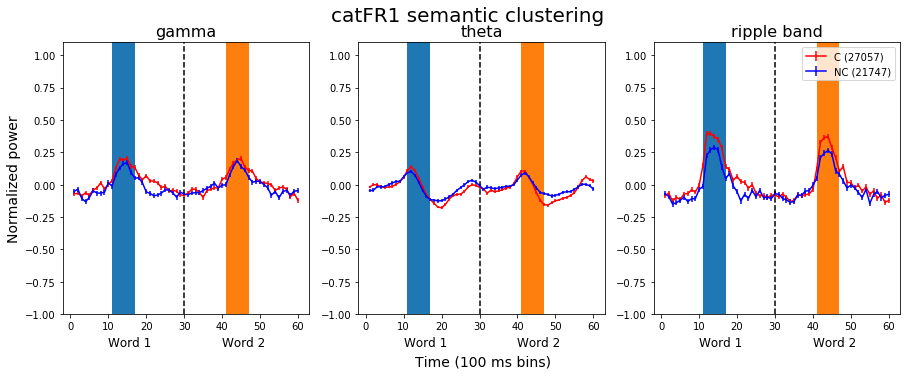

In [348]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered, no_clustered,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 semantic clustering')

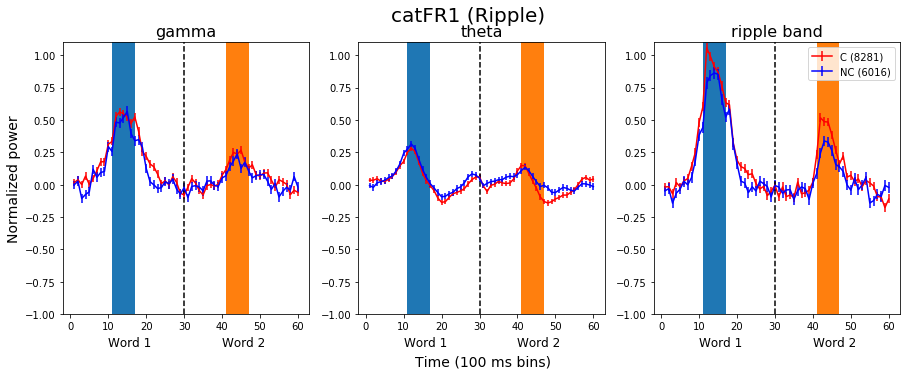

In [315]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered_ripple, no_clustered_ripple,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 (Ripple)')

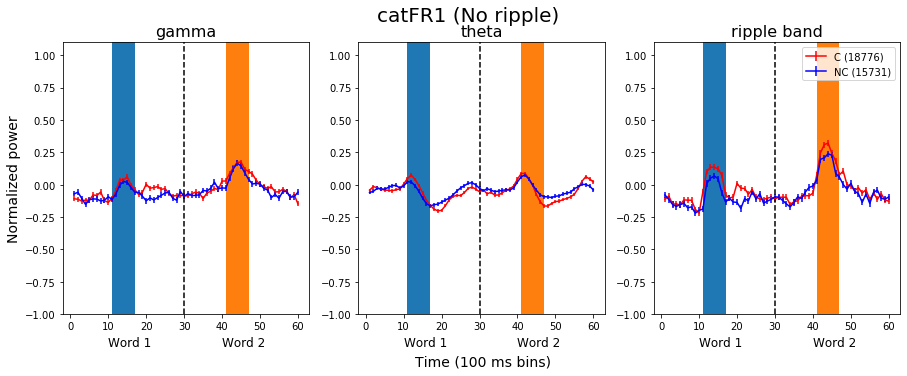

In [314]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered_no_ripple, no_clustered_no_ripple,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 (No ripple)')

In [375]:
clustered_array = create_semantic_clustered_array(clustered=['A'], unclustered=['D', 'Z'])
clustered, no_clustered, clustered_ripple, clustered_no_ripple, no_clustered_ripple, no_clustered_no_ripple = convert_clustered_to_idxs(clustered_array, True)

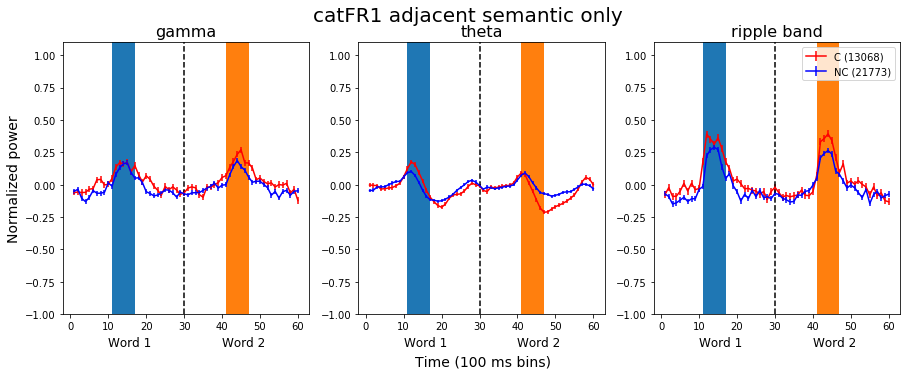

In [376]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered, no_clustered,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 adjacent semantic only')

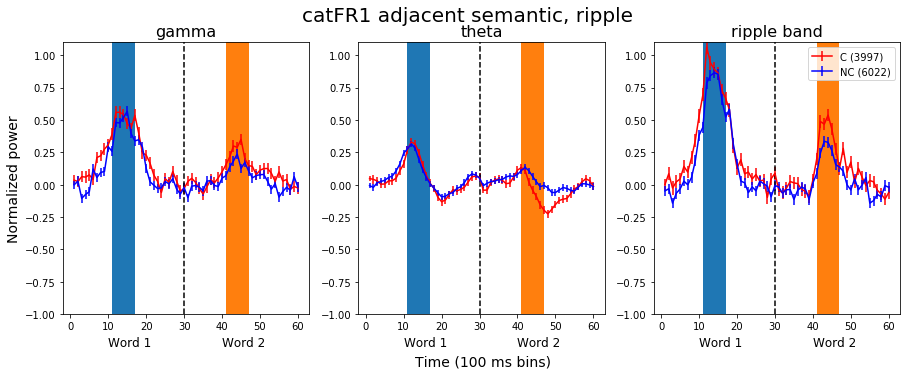

In [377]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered_ripple, no_clustered_ripple,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 adjacent semantic, ripple')

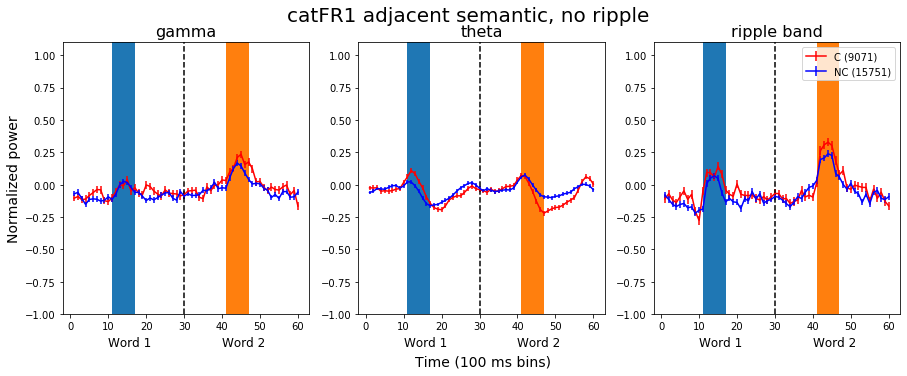

In [378]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered_no_ripple, no_clustered_no_ripple,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 adjacent semantic, no ripple')

In [374]:
clustered_array = create_semantic_clustered_array(clustered=['C'], unclustered=['D', 'Z'])
clustered, no_clustered, clustered_ripple, clustered_no_ripple, no_clustered_ripple, no_clustered_no_ripple = convert_clustered_to_idxs(clustered_array, True)

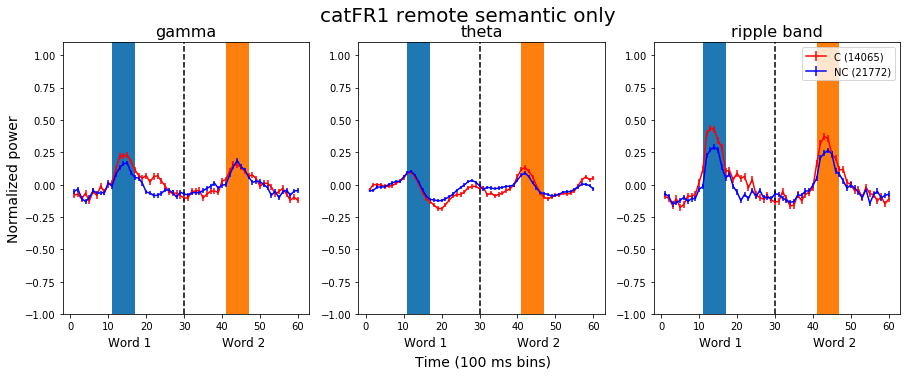

In [371]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered, no_clustered,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 remote semantic only')


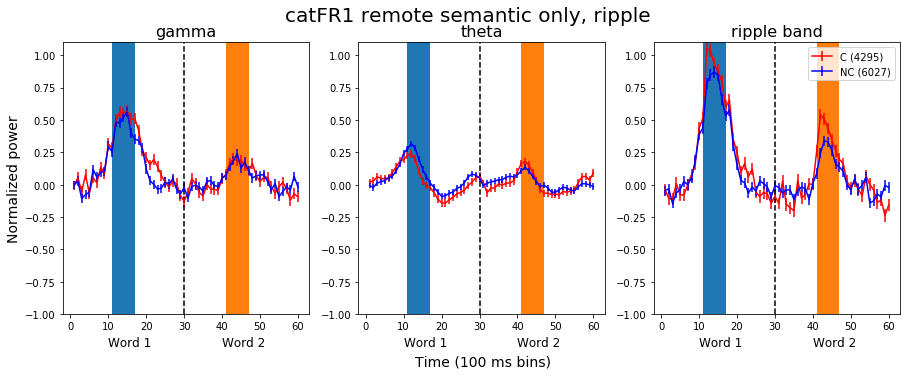

In [372]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered_ripple, no_clustered_ripple,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 remote semantic only, ripple')

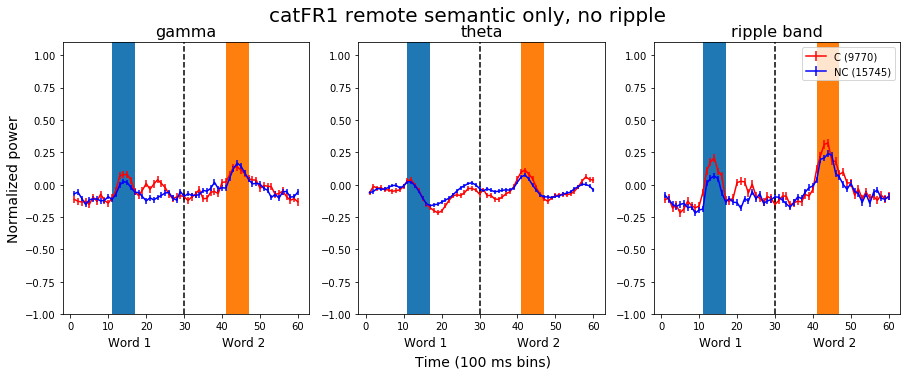

In [373]:
f1, f2 = plot_clustered_vs([RS.gamma_array_np, RS.theta_array_np, RS.ripple_freq_array_np], 
                                      ['gamma', 'theta', 'ripple band'],
                                       clustered_no_ripple, no_clustered_no_ripple,
                                       label1='C', 
                                       label2='NC', append_next_word=True, title='catFR1 remote semantic only, no ripple')